In [1]:
import json
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import os
import random
import numpy as np

# 0. Leemos los datos

In [2]:
def read_json(path):
    with open(path) as f:
        data = json.load(f)
    return data

def leer_k_archivos_json(k):
    archivos_json = [archivo for archivo in os.listdir("data") if archivo.endswith('.json')]
    random.seed(42)
    paths = random.choices(archivos_json, k=k)

    all_playlists = []
    for p in paths:
        data = read_json(f"data\{p}")
        playlist = pd.DataFrame(data['playlists'])
        all_playlists.append(playlist)

    playlists = pd.concat(all_playlists, ignore_index=True)
    return playlists

In [3]:
# Leer 10 archivos json osea 10000 playlists
playlists = leer_k_archivos_json(10)
playlists.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,random,false,674000,1479168000,141,117,1,"[{'pos': 0, 'artist_name': 'R.E.M.', 'track_ur...",26,36307284,81,NaN
1,Summer 2015,false,674001,1471564800,191,155,1,"[{'pos': 0, 'artist_name': 'Kanye West', 'trac...",88,42162338,131,NaN
2,Dinner,false,674002,1501027200,26,24,1,"[{'pos': 0, 'artist_name': 'Dean Martin', 'tra...",2,6041217,21,NaN
3,Reggae,false,674003,1474156800,26,25,2,"[{'pos': 0, 'artist_name': 'Sizzla', 'track_ur...",4,5572231,16,NaN
4,angst,false,674004,1506902400,22,21,1,"[{'pos': 0, 'artist_name': 'Death Cab for Cuti...",5,5383303,19,NaN


In [4]:
playlists.isna().sum()

name                0
collaborative       0
pid                 0
modified_at         0
num_tracks          0
num_albums          0
num_followers       0
tracks              0
num_edits           0
duration_ms         0
num_artists         0
description      9821
dtype: int64

In [5]:
playlists["description"][~playlists["description"].isna()]

105                            it was a long ass semester
123           intertwining your soul with somebody else ✨
161            for all of your &quot;non-Hype&quot; moods
208         free lil kodak they dont like to see u wining
233     theese are all the song i recomend wile workin...
                              ...                        
9815                      my remix&#x2F;dance music phase
9870                                no description needed
9900    some very mainstream and basic music to dance ...
9927                           some good stuff right here
9939         Old school music (stuff that mom and I like)
Name: description, Length: 179, dtype: object

In [6]:
def expandir_tracks(playli):
    expanded_tracks_df = pd.DataFrame()

    # Iterar sobre cada fila y expandir los datos JSON en un dataframe
    for _, row in playli.iterrows():
        # Cargar el JSON desde la columna 'tracks'
        tracks = row['tracks']

        # Comprobar si 'tracks' es una cadena que necesita ser convertida de JSON
        if isinstance(tracks, str):
            try:
                tracks = json.loads(tracks)  # Cargar la cadena JSON
            except json.JSONDecodeError:
                tracks = []  # En caso de error, usar una lista vacía
        elif not isinstance(tracks, list):
            tracks = []  # Asegurar que tracks sea una lista si no es una cadena

        if tracks:
            track_data = json_normalize(tracks)
            track_data['pid'] = row['pid']  # añadimos el id de la playlist para mantener la referencia
            expanded_tracks_df = pd.concat([expanded_tracks_df, track_data], ignore_index=True)
    return expanded_tracks_df

In [7]:
expanded_tracks_df = expandir_tracks(playlists)

In [8]:
playlists.drop("tracks", axis=1, inplace=True)
playlists.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,description
0,random,false,674000,1479168000,141,117,1,26,36307284,81,NaN
1,Summer 2015,false,674001,1471564800,191,155,1,88,42162338,131,NaN
2,Dinner,false,674002,1501027200,26,24,1,2,6041217,21,NaN
3,Reggae,false,674003,1474156800,26,25,2,4,5572231,16,NaN
4,angst,false,674004,1506902400,22,21,1,5,5383303,19,NaN


In [9]:
by_playlist = expanded_tracks_df.groupby('pid').agg(
    num_songs=('track_name', 'count'),  # Contamos el número de canciones por playlist
    avg_duration=('duration_ms', 'mean'),  # Calculamos la duración media de las canciones
    artists=('artist_name', lambda x: set(x)),  # Obtenemos un conjunto de artistas únicos
    songs =('track_uri', lambda x: set(x)),  # Obtenemos un conjunto de caciones únicas
    albums =('album_name', lambda x: set(x))  # Obtenemos un conjunto de albumes únicos
)

by_playlist['avg_duration'] = by_playlist['avg_duration'] / 60000 # Convertimos la duración de milisegundos a minutos
# by_playlist.head()

In [10]:
playlist_per_song = expanded_tracks_df.groupby('track_uri')['pid'].agg(list).reset_index()
# playlist_per_song.head()

- Pasamos los URL a un id de cancion

In [11]:
url_id = {}
n = 1

def key_exists(key, dictionary):
    try:
        value = dictionary[key]
        return True
    except KeyError:
        return False

def get_id(x, n):
    if not key_exists(x, url_id):
        url_id[x] = n
        n += 1
    return url_id[x], n

values = []

for val in playlist_per_song["track_uri"]:
    valu, n = get_id(val, n)
    values.append(valu)

playlist_per_song["track_id"] = values
playlist_per_song.head()

,track_uri,pid,track_id
0,spotify:track:000pmJ2wC4EvNSbXa3aHwT,[176550],1
1,spotify:track:000xQL6tZNLJzIrtIgxqSl,"[674120, 674982, 120045, 120092, 120110, 12019...",2
2,spotify:track:000xYdQfIZ4pDmBGzQalKU,[674480],3
3,spotify:track:0010mZpCCwlPwoBiBsjoac,"[120352, 761127, 124129]",4
4,spotify:track:001BVhvaZTf2icV88rU3DA,"[346171, 707721, 478347]",5


In [12]:
expanded_tracks_df["track_id"] = expanded_tracks_df["track_uri"].apply(lambda x: url_id[x])

In [13]:
by_playlist["track_id"] = by_playlist["songs"].apply(lambda x: [url_id[val] for val in list(x)])
# by_playlist.head()

In [14]:
playlist_per_song['n_playlists'] = playlist_per_song['pid'].apply(lambda x: len(set(x)))

In [15]:
playlist_per_song["n_playlists"].mean()

3.839445982096328

In [16]:
cancion_mas_reproducida = playlist_per_song["n_playlists"].idxmax()
playlist_per_song.iloc[cancion_mas_reproducida]

track_uri                   spotify:track:1xznGGDReH1oQq0xzbwXa3
pid            [674001, 674041, 674050, 674058, 674069, 67407...
track_id                                                   43755
n_playlists                                                  442
Name: 43754, dtype: object

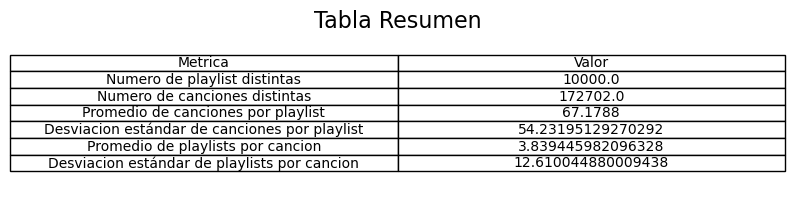

In [17]:
metricas = {
    'Metrica': ['Numero de playlist distintas', 'Numero de canciones distintas',
                'Promedio de canciones por playlist', 'Desviacion estándar de canciones por playlist',
                'Promedio de playlists por cancion', 'Desviacion estándar de playlists por cancion'],
    'Valor': [by_playlist.shape[0], len(expanded_tracks_df["track_uri"].unique()), by_playlist["num_songs"].mean(), by_playlist["num_songs"].std(),
              playlist_per_song["n_playlists"].mean(), playlist_per_song["n_playlists"].std()]
}

df = pd.DataFrame(metricas)

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
tabla = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colWidths=[0.5, 0.5])
plt.title('Tabla Resumen', fontsize=16)
plt.show()

Mantenemos solo las playlist con al menos 10 canciones

In [18]:
#Hay playlist que tienen la misma cancion más de una vez, aca las tratamos solo una vez
playlist_track = expanded_tracks_df[["pid","track_id","track_name","duration_ms","artist_name"]].drop_duplicates()
# playlist_track.head()

In [19]:
# Acá separamos en las playlists con un número de canciones mayor a NUM_CANCIONES
# Luego nos quedamos solo con las playlist con un número mayor para hacer el entrenamiento y el testeo
NUM_CANCIONES = 10
song_per_playlist = playlist_track.groupby('pid')['track_id'].agg(list).reset_index()
song_per_playlist['n_songs'] = song_per_playlist['track_id'].apply(len)
pid_less = song_per_playlist[song_per_playlist['n_songs'] < NUM_CANCIONES]['pid'].unique()
pid_more = song_per_playlist[song_per_playlist['n_songs'] >= NUM_CANCIONES]['pid'].unique()
print(len(pid_less), len(pid_more))

352 9648


In [20]:
len(pid_more)/by_playlist.shape[0]

0.9648

In [21]:
len(pid_less)/by_playlist.shape[0]

0.0352

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
# Acá hacemos una separación de las playlists que le vamos a entregar la información completa,
# y las que le vamos a entregar solo las primeras n

train_pid, test_pid = train_test_split(pid_more, test_size=0.2, random_state=42)
print(len(train_pid), len(test_pid))

7718 1930


In [24]:
song_per_playlist.drop("n_songs", axis=1, inplace=True)
song_per_playlist.head(3)

,pid,track_id
0,3000,"[64915, 122329, 18296, 163225, 80436, 146959, ..."
1,3001,"[136703, 156726, 48512, 30344, 103200, 156821,..."
2,3002,"[155266, 63130, 124133, 36885, 14275, 115421, ..."


Para el 20% separamos sus 5 pimeras canciones de las demas. (las 5 primeras serán usadas en train y las demas en el conjunto de testeo)

In [25]:
def Sep_first_n(n, pids):
    #Primero separamos las primeras n canciones de una playlist y las siguientes
    all = song_per_playlist[song_per_playlist['pid'].isin(pids)].copy()
    all.loc[:, 'fist_5'] = all['track_id'].apply(lambda x: x[:n])
    all.loc[:, 'next']= all['track_id'].apply(lambda x: x[n:])
    all.drop("track_id", axis=1, inplace=True)
    #Luego utilizamos las primeras n canciones para entrenar y las siguientes para testear
    train = all[['pid', 'fist_5']].explode('fist_5')
    test = all[['pid', 'next']].explode('next')
    train.rename(columns={'fist_5': 'track_id'}, inplace=True)
    test.rename(columns={'next': 'track_id'}, inplace=True)
    return train, test

In [26]:
# Acá separamos para las playlist que están en test sus primeras PRIMERAS_N canciones para train y el resto para train
# Hay que asegurarse que PRIMERAS_N << NUM_CANCIONES

PRIMERAS_N = 5
test_train, test_test = Sep_first_n(PRIMERAS_N, test_pid)

# clear_outputs()

In [27]:
# Luego acá creamos los datasets de train y test

data = playlist_track[['pid', 'track_id']]
train_data = data[data['pid'].isin(train_pid)]                       # Playlists con todas las canciones
train_data = pd.concat([train_data, test_train], ignore_index=True)  # Playlists con solo las PRIMERAS_N canciones
test_data = test_test


In [28]:
# Pequeño test para revisar cuantas canciones el modelo no se ha entrenado con, lo cual implica que no las va a poder recomendar
# Este número debería bajar si incluimos más data en el comienzo

test_tracks_ids = test_data['track_id'].unique()
train_tracks_ids = train_data['track_id'].unique()
tracks_not_in_train = np.setdiff1d(test_tracks_ids, train_tracks_ids)
tracks_not_in_train, len(tracks_not_in_train) / len(test_tracks_ids)

(array([13, 18, 23, ..., 172678, 172679, 172693], dtype=object),
 0.39359153166684546)

# Most Popular

In [29]:
def R_precision(recommended, actual):
    n = len(actual)
    recommended = recommended[:n]
    in_both = np.intersect1d(recommended, actual)
    return len(in_both) / n

def dcg(relevance_scores):
    return relevance_scores[0] + np.sum(
        [rel / np.log2(idx + 1) for idx, rel in enumerate(relevance_scores[1:], start=2)]
    )

def ndcg(recommended, actual):
    """Calculate Normalized Discounted Cumulative Gain (NDCG) at k"""
    # Relevance scores: 1 if the item is in the ground truth, 0 otherwise
    relevance_scores = [1 if item in actual else 0 for item in recommended]

    # Calculate DCG for the recommended list
    DCG = dcg(relevance_scores)

    # Calculate IDCG for the ideal list (the best possible ranking)
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)
    IDCG = dcg(ideal_relevance_scores)

    # Calculate NDCG
    NDCG = DCG / IDCG if IDCG > 0 else 0
    return NDCG

def rec_song_clicks(recommended, actual):
    for i, item in enumerate(recommended):
        if item in actual:
            clicks = np.floor(i / 10)
            return clicks
    return 51

In [30]:
user_ids = test_pid
print(len(user_ids))
print(train_data['track_id'].nunique())
r_prec = []
ndcgs = []
clicks = []

ids = train_data['track_id'].value_counts().index[0:500].to_list()
for userid in user_ids:
 
  actual = test_test[test_test['pid'] == userid]['track_id'].values

  # print(actual)
  r_prec.append(R_precision(ids, actual))
  ndcgs.append(ndcg(ids, actual))
  clicks.append(rec_song_clicks(ids, actual))

  # in_both = np.intersect1d(ids, actual)
  # if in_both.size > 0:
  #     print(in_both)

print(f"R prec: {np.mean(r_prec)}, NDCG: {np.mean(ndcgs)}, Clicks: {np.mean(clicks)}")

1930
150136
R prec: 0.025084451991659807, NDCG: 0.22074027180369993, Clicks: 19.661658031088084


# Random

In [31]:
user_ids = test_pid
print(len(user_ids))
print(train_data['track_id'].nunique())
r_prec = []
ndcgs = []
clicks = []
for userid in user_ids:

  # random
  ids = np.random.choice(train_data['track_id'].unique(), size=500, replace=False)
  actual = test_test[test_test['pid'] == userid]['track_id'].values

  # print(actual)
  r_prec.append(R_precision(ids, actual))
  ndcgs.append(ndcg(ids, actual))
  clicks.append(rec_song_clicks(ids, actual))
  
print(f"R prec: {np.mean(r_prec)}, NDCG: {np.mean(ndcgs)}, Clicks: {np.mean(clicks)}")

1930
150136
R prec: 0.00032854326764496044, NDCG: 0.02206979940377213, Clicks: 46.80051813471503


# New ALS

In [32]:
import implicit as implicit

c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import mean_average_precision_at_k, ndcg_at_k
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
train_interaction_matrix = csr_matrix((np.ones(len(train_data)), (train_data['pid'], train_data['track_id'])))
test_interaction_matrix = csr_matrix((np.ones(len(test_data)), (test_data['pid'], test_data['track_id'])))


model = AlternatingLeastSquares(factors=100, alpha = 20)
model.fit(train_interaction_matrix)

c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


In [35]:
test_test

,pid,track_id
0,3000,146959
0,3000,63793
0,3000,66369
0,3000,78526
0,3000,20469
...,...,...
9998,901998,70517
9998,901998,84648
9998,901998,135777
9998,901998,115900


In [36]:
# Pequeño código mostrando que el modelo efectivamente logra recomendar canciones relevantes para usuarios (playlists) del train
# Falta implementar las métricas, las clásicas de ndcg y r-precision y las que se crearon para la competencia

user_ids = test_pid
print(len(user_ids))
print(train_data['track_id'].nunique())
r_prec = []
ndcgs = []
clicks = []
for userid in user_ids:

  ids, scores = model.recommend(userid, train_interaction_matrix[userid], N=500, filter_already_liked_items=True)
  # print(ids, scores)
  actual = test_test[test_test['pid'] == userid]['track_id'].values
  # print(actual)

  r_prec.append(R_precision(ids, actual))
  ndcgs.append(ndcg(ids, actual))
  clicks.append(rec_song_clicks(ids, actual))

  # in_both = np.intersect1d(ids, actual)
  # if in_both.size > 0:
  #   print("Usuario: ", userid)
  #   print(in_both)

print(f"R prec: {np.mean(r_prec)}, NDCG: {np.mean(ndcgs)}, Clicks: {np.mean(clicks)}")

1930
150136
R prec: 0.11748838164223782, NDCG: 0.45647046151936554, Clicks: 5.147668393782383


# User-User

In [41]:
!pip install dask[complete] dask-ml

  Using cached dask_ml-2024.4.4-py3-none-any.whl.metadata (5.9 kB)
  Using cached dask_glm-0.3.2-py2.py3-none-any.whl.metadata (1.5 kB)
  Using cached sparse-0.15.4-py2.py3-none-any.whl.metadata (4.5 kB)
   ---------------------------------------- 0.0/956.9 kB ? eta -:--:--
   - -------------------------------------- 30.7/956.9 kB 1.3 MB/s eta 0:00:01
   ---------------- ----------------------- 389.1/956.9 kB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 956.9/956.9 kB 7.6 MB/s eta 0:00:00
Using cached dask_ml-2024.4.4-py3-none-any.whl (149 kB)
   ---------------------------------------- 0.0/18.5 MB ? eta -:--:--
   -- ------------------------------------- 1.4/18.5 MB 29.0 MB/s eta 0:00:01
   ------ --------------------------------- 3.0/18.5 MB 32.0 MB/s eta 0:00:01
   ---------- ----------------------------- 4.8/18.5 MB 33.8 MB/s eta 0:00:01
   -------------- ------------------------- 6.7/18.5 MB 35.6 MB/s eta 0:00:01
   -------------------- ------------------- 9.7/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cuda 23.4.0 requires distributed==2023.3.2.1, but you have distributed 2023.3.2 which is incompatible.


In [48]:
import dask.array as da
from dask import delayed

In [59]:
data = np.ones(len(train_data))
rows = train_data['pid'].values
cols = train_data['track_id'].values
shape = (train_data['pid'].max() + 1, train_data['track_id'].max() + 1)

train_interaction_matrix = csr_matrix((data, (rows, cols)), shape=shape)

In [54]:
num_blocks = 10  # Ajusta esto según el tamaño y la memoria disponible
block_size = train_interaction_matrix.shape[0] // num_blocks
blocks = [train_interaction_matrix[i*block_size:(i+1)*block_size] for i in range(num_blocks)]

In [55]:
delayed_results = [delayed(cosine_similarity)(block) for block in blocks]
dask_array_blocks = [da.from_delayed(result, shape=(block_size, train_interaction_matrix.shape[1]), dtype=np.float64) for result in delayed_results]

full_result = da.concatenate(dask_array_blocks, axis=0)

user_similarity = full_result.compute()

In [63]:
!pip install datasketch

   ---------------------------------------- 0.0/89.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/89.2 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/89.2 kB ? eta -:--:--
   --------- ------------------------------ 20.5/89.2 kB 330.3 kB/s eta 0:00:01
   ------------------ --------------------- 41.0/89.2 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------- 89.2/89.2 kB 632.0 kB/s eta 0:00:00


In [64]:
from datasketch import MinHashLSHForest, MinHash

# Configuración inicial
forest = MinHashLSHForest()

# Crear funciones de hash para cada fila (usuario o ítem)
for idx, vector in enumerate(train_interaction_matrix):
    m = MinHash(num_perm=128)  # Número de permutaciones, ajusta según la precisión deseada
    indices = vector.indices
    for i in indices:
        m.update(str(i).encode('utf8'))
    forest.add(idx, m)

forest.index()

In [73]:
r_prec = []
ndcgs = []
clicks = []

train_interaction_matrix_t = train_interaction_matrix.transpose()

for userid in test_pid:
    # Consulta para encontrar usuarios similares
    query_user_vector = train_interaction_matrix[userid]
    query_minhash = MinHash(num_perm=128)
    for data_point in query_user_vector.indices:
        query_minhash.update(str(data_point).encode('utf8'))

    # Encuentra los 10 usuarios más similares
    similar_users = forest.query(query_minhash, 10)

    # Resto del código para generar recomendaciones...
    song_values = []
    songs = train_interaction_matrix[similar_users]
    unique_songs = songs.tocsr().indices
    for song_id in unique_songs:
        ids = train_interaction_matrix_t[song_id]
        ids = list(ids.tocsr().indices)

        score = np.sum(user_similarity[userid][ids])
        song_values.append((song_id, score))
    
    recommended_songs = [song_id for song_id, _ in sorted(song_values, key=lambda x: x[1], reverse=True)][:500]
    ids = recommended_songs
    actual = test_test[test_test['pid'] == userid]['track_id'].values

    if len(ids) == 0:
        r_prec.append(0)
        ndcgs.append(0)
        clicks.append(0)
        continue

    r_prec.append(R_precision(ids, actual))
    ndcgs.append(ndcg(ids, actual))
    clicks.append(rec_song_clicks(ids, actual))

print(f"R prec: {np.mean(r_prec)}, NDCG: {np.mean(ndcgs)}, Clicks: {np.mean(clicks)}")

NameError: name 'user_similarity' is not defined

# New Item Item

In [34]:
item_model = implicit.nearest_neighbours.CosineRecommender(K=500)
item_model.fit(train_interaction_matrix)

c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002986907958984375 seconds
  warnings.warn(
  0%|          | 0/56536 [00:00<?, ?it/s]

100%|██████████| 56536/56536 [00:00<00:00, 99887.43it/s] 


In [35]:
user_ids = test_pid
print(len(user_ids))
print(train_data['track_id'].nunique())
r_prec = []
ndcgs = []
clicks = []
for userid in user_ids:

  ids, scores = item_model.recommend(userid, train_interaction_matrix[userid], N=500, filter_already_liked_items=True)
  actual = test_test[test_test['pid'] == userid]['track_id'].values

  r_prec.append(R_precision(ids, actual))
  ndcgs.append(ndcg(ids, actual))
  clicks.append(rec_song_clicks(ids, actual))


print(f"R prec: {np.mean(r_prec)}, NDCG: {np.mean(ndcgs)}, Clicks: {np.mean(clicks)}")

386
49414
R prec: 0.0440609572092963, NDCG: 0.27846394183617673, Clicks: 16.145077720207254


# Ejemplo

In [37]:
pares = expanded_tracks_df[["artist_name","track_name","track_uri","track_id"]].drop_duplicates().sort_values("track_id")

In [102]:
songs_ids =[3663, 4546, 8544, 10600, 10646]

In [101]:
pares[pares["artist_name"] == "Ed Sheeran"]

,artist_name,track_name,track_uri,track_id
26606,Ed Sheeran,One,spotify:track:0A2J5TumCpT4aJVvQHNEQW,3663
140777,Ed Sheeran,One Night,spotify:track:0CNrpbpJ9HsFffF9hqWIIe,4546
69298,Ed Sheeran,New York,spotify:track:0NJDrEZdTbVPMKC0Zbglgn,8544
4106,Ed Sheeran,Give Me Love,spotify:track:0SuG9kyzGRpDqrCWtgD6Lq,10600
140775,Ed Sheeran,Homeless - Live At The Bedford,spotify:track:0T0wYEzpL46dCaTL1DLCyD,10646
...,...,...,...,...
182394,Ed Sheeran,You - +Wiley,spotify:track:7h7KBBdYIzrxOsLfR9aUO7,165867
178111,Ed Sheeran,Bloodstream - Arty Remix,spotify:track:7hsXDbHfhcm9hDpK7DJyhi,166154
64682,Ed Sheeran,Autumn Leaves - Deluxe Edition,spotify:track:7iBSkXB0pTvZasOLf0Qxk9,166259
7021,Ed Sheeran,Eraser,spotify:track:7oolFzHipTMg2nL7shhdz2,168693


In [38]:
trackname_id = {(row['artist_name'], row['track_name']): row['track_id'] for _, row in pares.iterrows()}
id_trackname = {row['track_id']: (row['artist_name'], row['track_name']) for _, row in pares.iterrows()}

In [ ]:
selecting = True
songs = 0

songs_ids= []
while selecting:
    
    artist = input("Ingrese el nombre del artista: ")
    song = input("Ingrese el nombre de la canción: ")

    if (artist, song) in trackname_id:
        print("La canción está en el dataset")
        songs_ids.append(trackname_id[(artist, song)])
        songs += 1
    else:
        print("La canción no está en el dataset")
    if songs == 5:
        selecting = False

La canción no está en el dataset
La canción no está en el dataset
La canción no está en el dataset
La canción no está en el dataset
La canción no está en el dataset
La canción no está en el dataset
La canción no está en el dataset
La canción está en el dataset
La canción no está en el dataset
La canción está en el dataset
La canción está en el dataset
La canción está en el dataset
La canción está en el dataset


In [41]:
unique_songs = train_data['track_id'].unique()

In [47]:
item_id_to_index = {song_id: index for index, song_id in enumerate(unique_songs)}
index_to_item_id = {index: item_id for item_id, index in item_id_to_index.items()}

In [103]:
initial_indices = [item_id_to_index[id] for id in songs_ids]

initial_factors = np.array([model.item_factors[idx] for idx in initial_indices])

# Calcular el vector promedio (o sumar y normalizar)
average_vector = np.mean(initial_factors, axis=0)

# Calcular la similitud con todas las otras canciones
similarities = model.item_factors.dot(average_vector)

# Obtener los índices de los top 5 recomendaciones (excluyendo las canciones iniciales)
recommended_indices = np.argsort(-similarities)[:len(songs_ids) + 5]
recommended_indices = [idx for idx in recommended_indices if idx not in initial_indices][:5]

In [104]:
recommended_indices

[54080, 128801, 103032, 120728, 172277]

In [105]:
for r in recommended_indices:
    print(id_trackname[r])

('The Neighbourhood', 'Sweater Weather')
('The Shins', 'New Slang')
('Peter Bjorn and John', 'Young Folks')
('The Temper Trap', 'Sweet Disposition')
('Vance Joy', 'Riptide')
